In [27]:
import requests
import numpy as np
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt

# I. CRAWL DATA (DATA COLLECTION)
- To crawl data programmatically from the FRED (Federal Reserve Economic Data) website for the "Crude Oil Prices: Brent - Europe (DCOILBRENTEU)" series
- Source " https://fred.stlouisfed.org/series/DCOILBRENTEU

In [28]:
import pandas as pd

def get_fred_data(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json'
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        observations = data['observations']
        
        df = pd.DataFrame(observations)
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        
        # Drop the realtime_start and realtime_end columns
        df = df.drop(columns=['realtime_start', 'realtime_end'])
        
        # Rename the 'value' column to 'prices (Dollars per Barrel)'
        df = df.rename(columns={'value': 'prices (Dollars per Barrel)'})
        
        return df
    else:
        print("Failed to fetch data")
        return None

#  need to obtain an API key from FRED by registering on their website.
api_key = 'd8100403cfe90e66d71fa008fe778397'
series_id = 'DCOILBRENTEU'

# Get data
df = get_fred_data(series_id, api_key)
df.tail()


,date,prices (Dollars per Barrel)
9670,2024-06-12,80.52
9671,2024-06-13,81.44
9672,2024-06-14,81.49
9673,2024-06-17,82.45
9674,2024-06-18,84.79


In [29]:
df.shape

(9675, 2)

# II. DATA PREPROCESSING

- Remove duplicates 
- Handle missing values
- Convert Data types
- Detect and Handle outliers


## 1. Check duplicate and null value and display data types

In [30]:
# Check duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Check null values
print("Number of null values in each column:\n", df.isnull().sum())

# Display data types
print("Data types of each column:\n", df.dtypes)

Number of duplicate rows: 0
Number of null values in each column:
 date                             0
prices (Dollars per Barrel)    266
dtype: int64
Data types of each column:
 date                            object
prices (Dollars per Barrel)    float64
dtype: object


## 2. Remove duplicate & null value and Set data types

In [31]:
df = df.drop_duplicates()
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])
df['prices (Dollars per Barrel)'] = df['prices (Dollars per Barrel)'].astype(float)
df.shape

(9409, 2)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9409 entries, 0 to 9674
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9409 non-null   datetime64[ns]
 1   prices (Dollars per Barrel)  9409 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 220.5 KB


## 3. Identify outlier and Visualize outlier

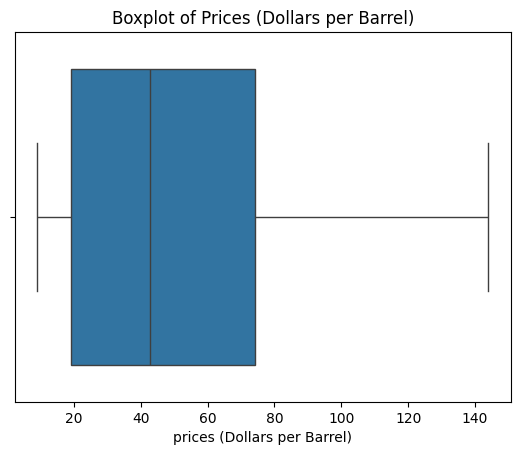

In [33]:
Q1 = df['prices (Dollars per Barrel)'].quantile(0.25)
Q3 = df['prices (Dollars per Barrel)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Boxplot
sns.boxplot(x=df['prices (Dollars per Barrel)'])
plt.title('Boxplot of Prices (Dollars per Barrel)')
plt.show()

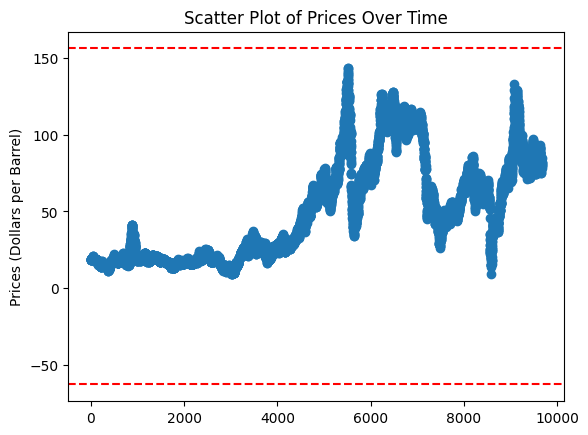

In [34]:
# Scatter Plot
plt.scatter(x=df.index, y=df['prices (Dollars per Barrel)'])
plt.axhline(y=lower_bound, color='r', linestyle='--')
plt.axhline(y=upper_bound, color='r', linestyle='--')
plt.title('Scatter Plot of Prices Over Time')
plt.ylabel('Prices (Dollars per Barrel)')
plt.show()

<p>Outlier Identification: The red dashed lines indicate the typical bounds for outliers based on the interquartile range (IQR). Points that fall above the upper red dashed line or below the lower red dashed line would be considered outliers. From this plot, it appears that there are several potential outliers, especially on the upper end, where prices spike well above the upper threshold.<p/>

## 4. Save the DataFrame to a CSV file

In [35]:
if df is not None:
    file_path = 'crude_oil_prices.csv'
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Delete the file if it exists
        os.remove(file_path)
        print(f"Existing file '{file_path}' has been deleted.")
    
    # Save the DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Data saved to '{file_path}'")
else:
    print("No data to save.")

Existing file 'crude_oil_prices.csv' has been deleted.
Data saved to 'crude_oil_prices.csv'


# III. Exploration Data Analysis (EDA)

## 1. Time series plot to show the prices over time

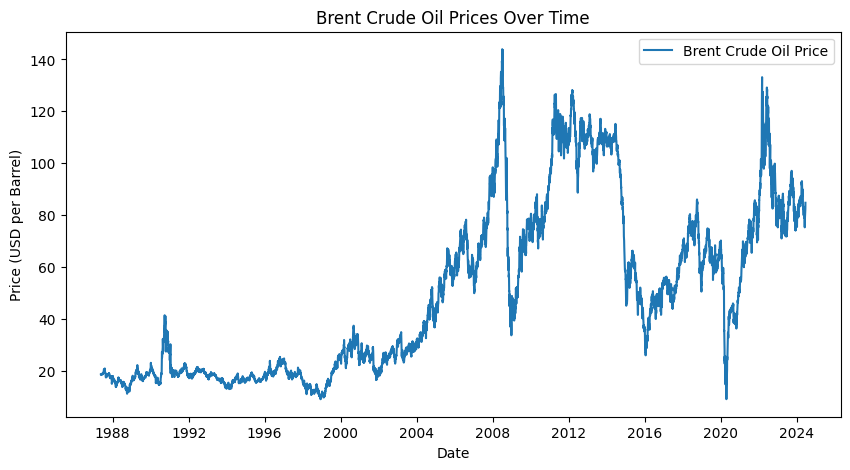

In [36]:
df['date'] = pd.to_datetime(df['date'])  # Ensure the date column is in datetime format
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['prices (Dollars per Barrel)'], label='Brent Crude Oil Price')
plt.title('Brent Crude Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.show()

The graph titled "Brent Crude Oil Prices Over Time" depicts the price movements of Brent crude oil from 1988 to around 2024. Here are some observations and explanations for the trends and fluctuations shown:

1. Observations and Analysis:
Long-Term Trend: The long-term trend shows significant growth from 1988 to a peak around 2008, followed by high volatility and a general upward tendency until another peak around 2014, after which prices show a notable drop and continue to fluctuate widely.

2. Periods of High Volatility:

- 2008 Financial Crisis: A sharp peak around 2008 corresponds to the global financial crisis, where oil prices hit record highs before crashing down dramatically as global demand plummeted.
- 2014 Oil Price Crash: The next sharp fall around 2014-2016 can be linked to a combination of factors including U.S. shale oil production increases, OPEC’s strategy shifts (e.g., not cutting production), and weakening global demand.

3. Recovery and Drops Post-2014: After the 2014 crash, prices recover somewhat but remain susceptible to various global economic and political pressures, including trade wars, production changes by major oil-producing countries, and geopolitical tensions.

4. COVID-19 Pandemic: The recent dip observed around 2020 is likely due to the COVID-19 pandemic, which led to unprecedented drops in demand for oil as travel restrictions were imposed worldwide, and economic activity slowed down.

5. Post-Pandemic Fluctuations: Following the pandemic, the prices appear to recover somewhat as global economies began to reopen and demand for oil increased, though the recovery shows signs of fluctuation possibly due to ongoing global economic uncertainties and supply chain issues.

6. Others:
- Supply and Demand Dynamics: Fundamental to the oil market, changes in supply (e.g., OPEC decisions, shale oil production) and demand (e.g., economic growth rates) heavily influence prices.
Geopolitical Factors: Political instability in key oil-producing regions can lead to supply disruptions, affecting prices.
- Economic Indicators: Global economic health, indicated by factors like GDP growth rates, manufacturing activity, and consumption patterns, also plays a critical role in oil pricing.
- Speculative Trading: The role of traders and investors speculating on oil price movements based on expected future developments can lead to price swings.

**Conclusion:
The graph reflects the complex interplay of various economic, political, and technical factors that influence oil prices. Understanding these can help stakeholders and analysts predict future trends and make informed decisions. The data suggests a market sensitive to global events with potential for both rapid growth and decline, highlighting the importance of strategic planning in industries reliant on oil.**

## 2. Histogram to know the distribution of prices

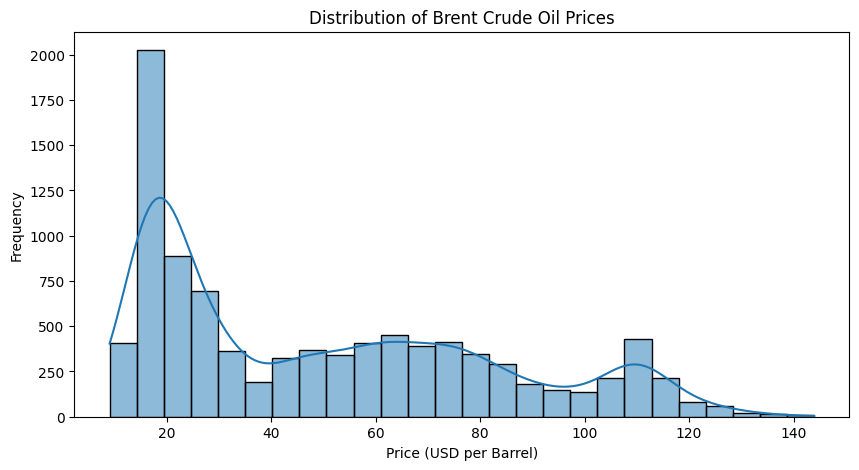

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['prices (Dollars per Barrel)'], kde=True)
plt.title('Distribution of Brent Crude Oil Prices')
plt.xlabel('Price (USD per Barrel)')
plt.ylabel('Frequency')
plt.show()

### Evaluations:
- Market Volatility: The broad spread of the distribution from very low to very high prices highlights the volatility in the Brent crude oil market. Such volatility can be driven by a variety of factors including economic changes, political instability, supply and demand imbalances, and speculations.

- Economic Implications: The periods where prices are extremely high or low could have significant economic implications for oil-producing countries and global economic stability. Low prices might lead to reduced revenues for oil-dependent economies, whereas high prices can contribute to inflation and slow down economic growth in oil-importing countries.